In [1]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.Sarimax import Sarimax
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima
from skforecast.ForecasterSarimax import ForecasterSarimax

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

import joblib



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SARIMAX for Luzon
DATA PREPROCESSING

In [2]:
labels_csv = r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/train_labels_transformed.csv'
data_csv = r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/train_data_transformed.csv'
test_data_csv=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/test_data.csv'
test_labels_csv=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/test_labels.csv'
transformed_data=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/data_transformed.csv'
complete_data = '/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/LUZ_Daily_Complete.csv'

transformed_train_data = pd.read_csv(data_csv)
transformed_train_labels = pd.read_csv(labels_csv)
transformed_data = pd.read_csv(transformed_data)

test_data = pd.read_csv(test_data_csv)
test_labels = pd.read_csv(test_labels_csv)

complete_data_df = pd.read_csv(complete_data)
gwap = complete_data_df[['GWAP']]
lwap = complete_data_df[['LWAP']]



In [3]:
train_size = int(len(transformed_train_labels))  
test_size = int(len(test_data))

date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])

train_date = date_df[:train_size]
test_date = date_df[train_size:]

#Resetting the Index
train_date = train_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)


In [4]:
#Preparing the dataframes
transformed_train_labels.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_test = pd.DataFrame(test_labels, columns = labels_columns)
transformed_train_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)
data_columns = ['FLOW_LUZ', 'Hourly Demand', 'TMAX_Cubi Point', 'TMAX_NAIA', 'TMIN_NAIA', 'TMAX_Science Garden', 'TMAX_SanJose', 'TMIN_SanJose', 'TMAX_Tayabas', 'TMIN_Tayabas', 'TMAX_CLSU', 'TMIN_CLSU', 'TMAX_Ambulong', 'TMAX_Casiguran', 'TMIN_Casiguran', 'TMAX_Clark', 'TMIN_Clark', 'TMAX_Calapan', 'TMIN_Calapan', 'GWAP', 'LWAP', 'TMIN_Cubi Point', 'TMIN_Science Garden', 'TMIN_Ambulong', 'RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr', 'RAINFALL_Cubi Point', 'RAINFALL_NAIA', 'RAINFALL_Science Garden', 'RAINFALL_San Jose', 'RAINFALL_Tayabas', 'RAINFALL_CLSU', 'RAINFALL_Tanay', 'TMAX_Tanay', 'TMIN_Tanay', 'RAINFALL_Ambulong', 'RAINFALL_Casiguran', 'RAINFALL_Clark', 'RAINFALL_Calapan']
data_train = pd.DataFrame(transformed_train_data)
data_test = pd.DataFrame(test_data, columns = data_columns)

transformed_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)


In [5]:
#lagging the transformed data
transformed_data = transformed_data.shift(1)
transformed_data = transformed_data.fillna(0)

#Removing GWAP and LWAP
transformed_exog = transformed_data.drop(columns=['GWAP','LWAP'])

#Preparing the exog datasets
train_exog = transformed_exog[:train_size]
test_exog = transformed_exog[train_size:]



In [6]:
#Preparing transformed GWAP datasets
GWAP_train = labels_train['GWAP']
GWAP_train = pd.concat([train_date,GWAP_train], axis=1)
GWAP_train.set_index('Date', inplace=True)
GWAP_train.index = pd.to_datetime(GWAP_train.index)
GWAP_train.index.freq='D'
GWAP_train = GWAP_train.squeeze()


GWAP_test = labels_test['GWAP']
GWAP_test = pd.concat([test_date,GWAP_test], axis=1)
GWAP_test.set_index('Date', inplace=True)
GWAP_test.index = pd.to_datetime(GWAP_test.index)
GWAP_test.index.freq='D'
GWAP_test = GWAP_test.squeeze()

#Preparing original GWAP datasets
GWAP = pd.concat([date_df,gwap], axis=1)
GWAP.set_index('Date', inplace=True)
GWAP.index = pd.to_datetime(GWAP.index)
GWAP.index.freq='D'
GWAP = GWAP.squeeze()

GWAP_test_inversed = GWAP[train_size:]




#Preparing the transformed LWAP datasets
LWAP_train = labels_train['LWAP']
LWAP_train = pd.concat([train_date,LWAP_train], axis=1)
LWAP_train.set_index('Date', inplace=True)
LWAP_train.index = pd.to_datetime(LWAP_train.index)
LWAP_train.index.freq='D'
LWAP_train = LWAP_train.squeeze()

LWAP_test = labels_test['LWAP']
LWAP_test = pd.concat([test_date,LWAP_test], axis=1)
LWAP_test.set_index('Date', inplace=True)
LWAP_test.index = pd.to_datetime(LWAP_test.index)
LWAP_test.index.freq='D'
LWAP_test = LWAP_test.squeeze()

#Preparing the original LWAP datasets

LWAP = pd.concat([date_df,lwap], axis=1)
LWAP.set_index('Date', inplace=True)
LWAP.index = pd.to_datetime(LWAP.index)
LWAP.index.freq='D'
LWAP = LWAP.squeeze()

LWAP_test_inversed = LWAP[train_size:]



#Preparing the exogenous datasets
exog_train = pd.concat([train_date,train_exog], axis=1)
exog_train.set_index('Date', inplace=True)

test_exog = pd.DataFrame(test_exog)
test_exog = test_exog.reset_index()
exog_test = pd.concat([test_date,test_exog], axis=1)
exog_test.set_index('Date', inplace=True)
exog_test = exog_test.drop(columns=['index'])

In [7]:
#Plotting Train LWAP ang GWAP
# Create the line plot
gwap_plot = px.line(GWAP_train, x=GWAP_train.index, y='GWAP')
lwap_plot = px.line(LWAP_train, x=LWAP_train.index, y='LWAP')
# Set the title using the ticker value
gwap_plot.update_layout(title=f"Luzon GWAP")
lwap_plot.update_layout(title=f"Luzon LWAP")
# Display the plot
gwap_plot.show()
lwap_plot.show()

In [8]:
def perform_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Check initial stationarity
    for i in range(max_differences):
        adf_p_value = adf_test(data)
        kpss_p_value = kpss_test(data)

        # If ADF p-value is less than 0.05 and KPSS p-value is greater than 0.05, it's stationary
        if adf_p_value < 0.05 and kpss_p_value > 0.05:
            print(f"Data is stationary after differencing {i} times.")
            return data

        # If not stationary, apply differencing
        data = data.diff().dropna()

    print(f"Data could not be made stationary after {max_differences} differencing operations.")
    return data

#same test for dataframe
def perform_df_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS 
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Store in new DataFrame
    diff_exog = pd.DataFrame(index=data.index)

    # Check each column in the DataFrame
    for column in data.columns:
        series = data[column].copy()  # Copy the series to avoid modifying the original

        for i in range(max_differences):
            adf_p_value = adf_test(series)
            kpss_p_value = kpss_test(series)

            # If stationary, break the loop and store the series
            if adf_p_value < 0.05 and kpss_p_value > 0.05:
                print(f"Column '{column}' is stationary after differencing {i} times.")
                diff_exog[column] = series  # Store the stationary series
                break

            # If not stationary, apply differencing
            if i < max_differences - 1:  # Don't drop NA on the last iteration
                series = series.diff().dropna()

        else:  # This else corresponds to the for-loop
            print(f"Column '{column}' could not be made stationary after {max_differences} differencing operations.")
            diff_exog[column] = series  # Store the last differenced result

    return diff_exog


In [9]:
#Checking for stationarity in GWAP data
perform_differencing(GWAP_train)
perform_differencing(LWAP_train)



Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Date
2022-01-01    0.258105
2022-01-02    0.314556
2022-01-03    0.418724
2022-01-04    0.501099
2022-01-05    0.787813
                ...   
2023-08-03    0.317026
2023-08-04    0.432209
2023-08-05    0.410919
2023-08-06    0.415499
2023-08-07    0.426566
Freq: D, Name: LWAP, Length: 584, dtype: float64

In [10]:
diff_exog_train = perform_df_differencing(exog_train)
diff_exog_train = diff_exog_train.fillna(0)

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value retu

Column 'FLOW_LUZ' is stationary after differencing 0 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'TMAX_Cubi Point' is stationary after differencing 0 times.
Column 'TMAX_NAIA' is stationary after differencing 0 times.
Column 'TMIN_NAIA' is stationary after differencing 0 times.
Column 'TMAX_Science Garden' is stationary after differencing 0 times.
Column 'TMAX_SanJose' is stationary after differencing 0 times.
Column 'TMIN_SanJose' is stationary after differencing 1 times.
Column 'TMAX_Tayabas' is stationary after differencing 0 times.
Column 'TMIN_Tayabas' is stationary after differencing 1 times.
Column 'TMAX_CLSU' is stationary after differencing 1 times.
Column 'TMIN_CLSU' is stationary after differencing 1 times.
Column 'TMAX_Ambulong' is stationary after differencing 0 times.
Column 'TMAX_Casiguran' is stationary after differencing 1 times.
Column 'TMIN_Casiguran' is stationary after differencing 1 times.
Column 'TMAX_Clark' is stationary after 

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value retu

Column 'RAINFALL_Tayabas' is stationary after differencing 0 times.
Column 'RAINFALL_CLSU' is stationary after differencing 1 times.
Column 'RAINFALL_Tanay' is stationary after differencing 0 times.
Column 'TMAX_Tanay' is stationary after differencing 0 times.
Column 'TMIN_Tanay' is stationary after differencing 1 times.
Column 'RAINFALL_Ambulong' is stationary after differencing 0 times.
Column 'RAINFALL_Casiguran' is stationary after differencing 1 times.
Column 'RAINFALL_Clark' is stationary after differencing 0 times.
Column 'RAINFALL_Calapan' is stationary after differencing 0 times.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value retu

In [11]:
diff_exog_test = perform_df_differencing(exog_test)
diff_exog_test = diff_exog_test.fillna(0)


Column 'FLOW_LUZ' is stationary after differencing 1 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'TMAX_Cubi Point' is stationary after differencing 1 times.
Column 'TMAX_NAIA' is stationary after differencing 0 times.
Column 'TMIN_NAIA' is stationary after differencing 1 times.
Column 'TMAX_Science Garden' is stationary after differencing 0 times.
Column 'TMAX_SanJose' is stationary after differencing 1 times.
Column 'TMIN_SanJose' is stationary after differencing 1 times.
Column 'TMAX_Tayabas' is stationary after differencing 1 times.
Column 'TMIN_Tayabas' is stationary after differencing 0 times.
Column 'TMAX_CLSU' is stationary after differencing 0 times.
Column 'TMIN_CLSU' is stationary after differencing 1 times.
Column 'TMAX_Ambulong' is stationary after differencing 1 times.
Column 'TMAX_Casiguran' is stationary after differencing 1 times.
Column 'TMIN_Casiguran' is stationary after differencing 1 times.
Column 'TMAX_Clark' is stationary after 

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_79101/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value retu

In [12]:
#Checking GWAP for seasonality
from scipy.stats import kruskal

GWAP_train_weekly=pd.DataFrame(GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
GWAP_train_weekly['day_of_week'] = GWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_GWAP_train_weekly = [group['GWAP'].values for name, group in GWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_GWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 13.75404219114398
p-value: 0.03250762899891647
There are significant differences between the weekly groups.


In [13]:
#Checking LWAP for seasonality
LWAP_train_weekly=pd.DataFrame(GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
LWAP_train_weekly['day_of_week'] = LWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_LWAP_train_weekly = [group['GWAP'].values for name, group in LWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_LWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 13.75404219114398
p-value: 0.03250762899891647
There are significant differences between the weekly groups.


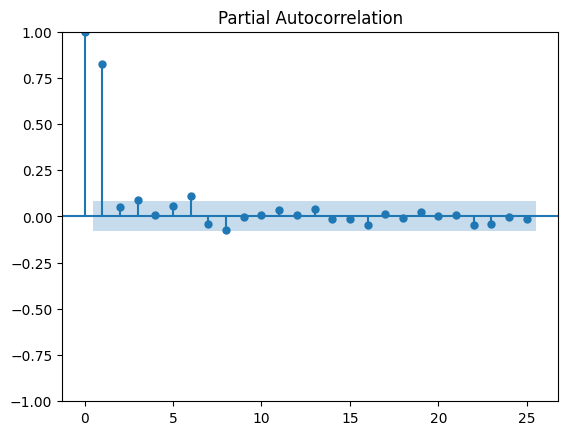

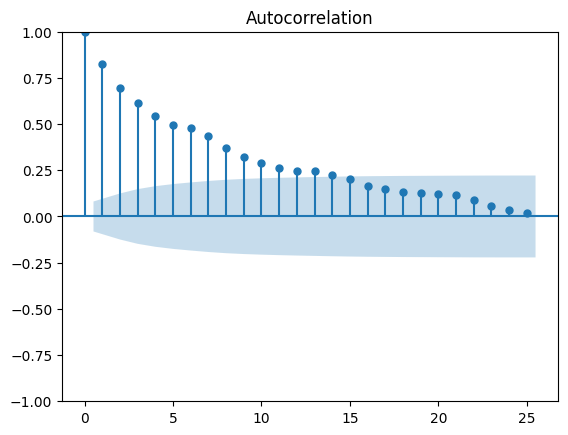

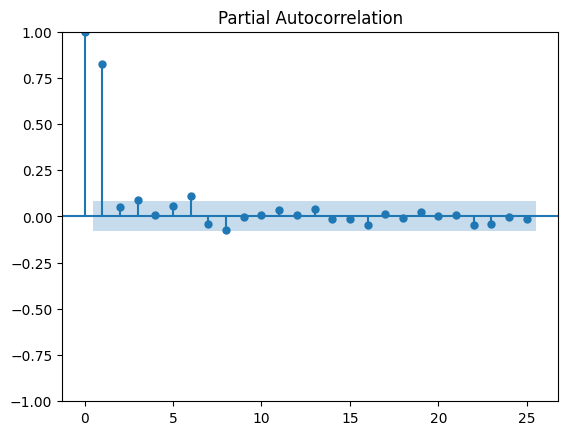

In [14]:
# Visualize autocorrelation using plot_acf
plot_acf(GWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(GWAP_train, lags=25, alpha=0.05)

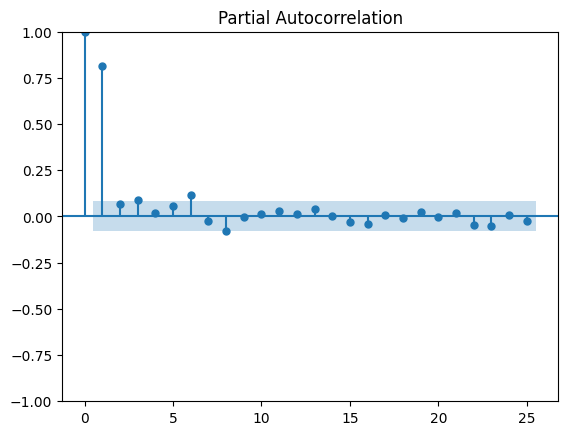

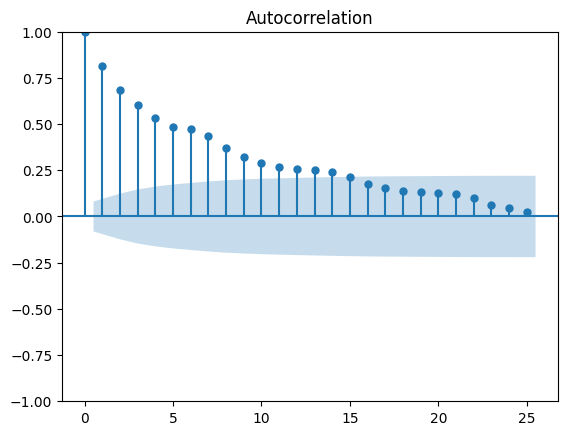

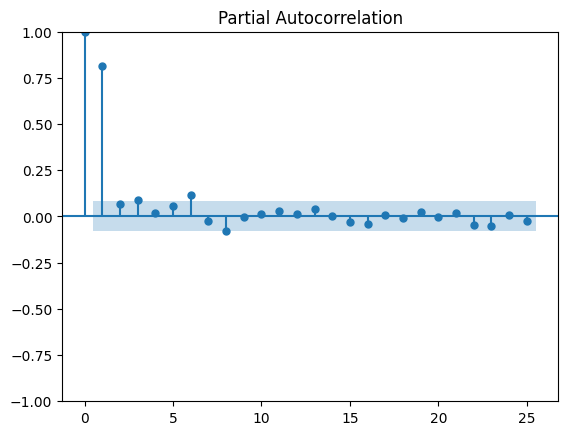

In [15]:
#LUZON LWAP
# Visualize autocorrelation using plot_acf
plot_acf(LWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LWAP_train, lags=25, alpha=0.05)

Forecast using statsmodels

In [16]:
#weekly seasonality
GWAP_sarimax_7 = auto_arima(GWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=13, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=diff_exog_train, iter=1000, method='bfgs')

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1019.602, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-1020.747, Time=0.32 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-1018.783, Time=0.84 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-1020.800, Time=0.11 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-1017.465, Time=2.61 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-1018.846, Time=0.28 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=-1017.184, Time=1.40 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-1033.009, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1034.434, Time=0.13 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-1032.617, Time=0.75 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-1034.567, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-1031.891, Time=2.39 sec
 ARIMA(0,1,1)

In [17]:
#Using statsmodels

gwap_model_weekly = SARIMAX(endog = GWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(1,0,0,7),  method='bfgs')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [18]:
fitted_gwap_model_weekly=gwap_model_weekly.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           43     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.76774D-01    |proj g|=  9.75588D-02


 This problem is unconstrained.



At iterate    5    f= -9.79356D-01    |proj g|=  5.07504D-02

At iterate   10    f= -9.83648D-01    |proj g|=  3.57136D-02


KeyboardInterrupt: 

In [44]:
gwap_train_predict = fitted_gwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)


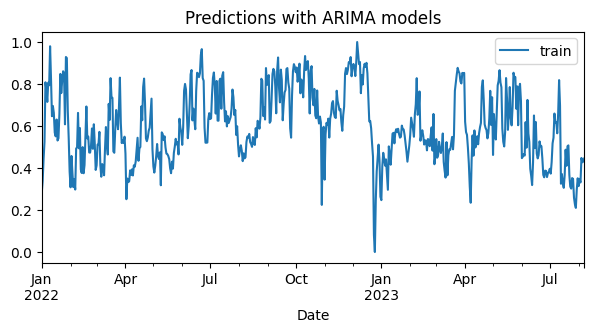

In [45]:
fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



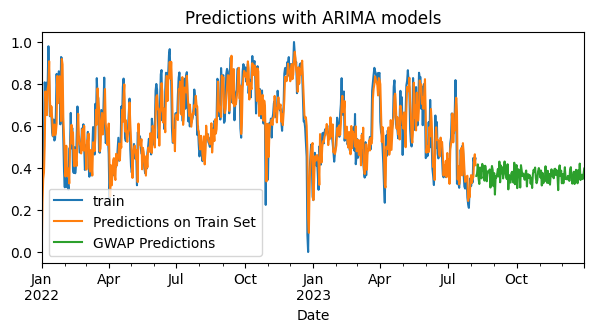

In [53]:
gwap_test_predict = fitted_gwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
gwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
gwap_test_predict.plot(ax=ax, label='GWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [48]:
LWAP_sarimax_7 = auto_arima(LWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=14, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=diff_exog_train, iter=1000, method='bfgs')

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-975.031, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-976.667, Time=0.33 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-975.102, Time=0.64 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-976.879, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-974.725, Time=1.71 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-975.386, Time=0.30 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=-974.120, Time=1.76 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-993.443, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-995.365, Time=0.14 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-994.136, Time=0.97 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-995.674, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-994.366, Time=2.45 sec
 ARIMA(0,1,1)(2,0,0)[7] i

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           45     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.44143D-01    |proj g|=  1.04917D-01

At iterate    5    f= -9.47474D-01    |proj g|=  6.50351D-02

At iterate   10    f= -9.52856D-01    |proj g|=  2.39035D-02

At iterate   15    f= -9.53530D-01    |proj g|=  8.89621D-03

At iterate   20    f= -9.53676D-01    |proj g|=  5.86075D-03

At iterate   25    f= -9.53829D-01    |proj g|=  2.83208D-02

At iterate   30    f= -9.54518D-01    |proj g|=  3.21619D-02

At iterate   35    f= -9.56709D-01    |proj g|=  1.22972D-01

At iterate   40    f= -9.58017D-01    |proj g|=  3.62352D-02

At iterate   45    f= -9.59135D-01    |proj g|=  3.54159D-02

At iterate   50    f= -9.59737D-01    |proj g|=  1.34168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



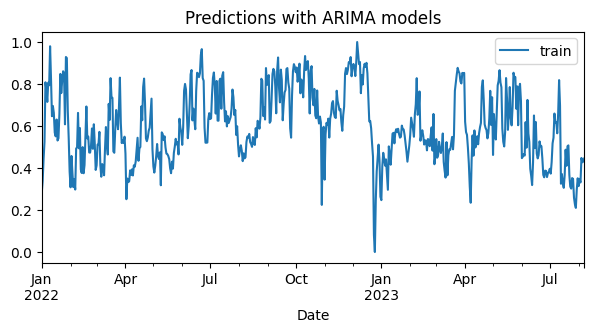

In [49]:
lwap_model_weekly = SARIMAX(endog = LWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(1,0,2,7),  method='bfgs')
fitted_lwap_model_weekly=lwap_model_weekly.fit()
#Check fit on train set
lwap_train_predict = fitted_lwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



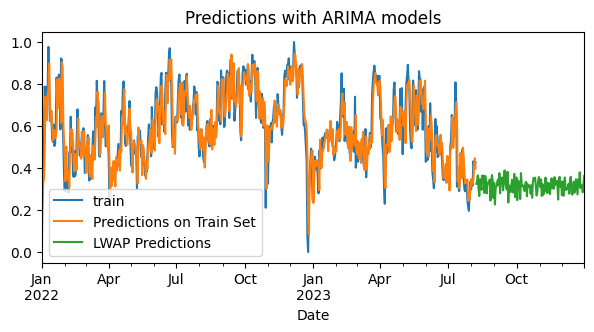

In [54]:
#Predict using LWAP mdodel and plot predictions
lwap_test_predict = fitted_lwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
lwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
lwap_test_predict.plot(ax=ax, label='LWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

Rolling Forecast

In [60]:

def rolling_forecast(train, test, exog_train, exog_test, order, season):
    """
    Perform rolling forecast with SARIMAX model, including exogenous variables.
    
    Parameters:
    - train: Series or DataFrame containing the target variable for training.
    - test: Series or DataFrame containing the target variable for testing.
    - exog_train: DataFrame containing the exogenous variables for training.
    - exog_test: DataFrame containing the exogenous variables for testing.
    - order: Tuple (p, d, q) representing the AR, I, and MA terms.
    - season: Tuple (P, D, Q, S) representing the seasonal AR, I, and MA terms with the seasonal period.
    
    Returns:
    - results: Dictionary containing predictions, mse, rmse, and mae.
    """
    history = [x for x in train]  # Start with training data
    exog_history = exog_train.iloc[0:len(train)]  # Corresponding exogenous data for training
    model = SARIMAX(history, exog=exog_history, order=order, seasonal_order=season)
    model_fit = model.fit(disp=False)
    
    predictions = []
    results = {}
    
    # First forecast (out of sample) using the first test point
    exog_forecast = exog_test.iloc[0:1]  # First test point's exogenous variables
    yhat = model_fit.forecast(exog=exog_forecast)[0]
    
    predictions.append(yhat)
    history.append(test[0])  # Add the first test observation to the history
    exog_history = pd.concat([exog_history, exog_test.iloc[0:1]])  # Use concat instead of append
    
    # Rolling forecast loop
    for i in range(1, len(test)):
        model = SARIMAX(history, exog=exog_history, order=order, seasonal_order=season)
        model_fit = model.fit(disp=False)
        
        exog_forecast = exog_test.iloc[i:i+1]  # Current test point exogenous variables
        yhat = model_fit.forecast(exog=exog_forecast)[0]
        
        predictions.append(yhat)
        
        obs = test[i]  # Actual test value
        history.append(obs)  # Append to history
        
        # Concatenate new exogenous data with history
        exog_history = pd.concat([exog_history, exog_test.iloc[i:i+1]])  # Use concat instead of append
    
    # Calculate error metrics
    rmse = mean_squared_error(test, predictions,squared=False)
    mae = mean_absolute_error(test, predictions)
    
    # Convert predictions to a pandas Series
    predictions = pd.Series(predictions, index=test.index)
    
    # Store results
    results['predictions'] = predictions
    results['rmse'] = rmse
    results['mae'] = mae
    
    return results

In [61]:
gwap_rolling_predictions = rolling_forecast(GWAP_train, GWAP_test, diff_exog_train, diff_exog_test, order=(1, 1, 1), season=(1,0,0,7))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Applying inverse transformations - non-rolling

In [51]:
#Applying the inverse transformations
#Loading inverse transformations for Luzon

minmax_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/boxcox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/yeojohnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/boxcox_pipeliney.pkl')

In [55]:
all_predictions = pd.concat([gwap_test_predict, lwap_test_predict], axis=1)
all_predictions_inverse=boxcoxy_fit_loaded.inverse_transform(all_predictions)
all_predictions_inverse

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but PowerTransformer was fitted with feature names



array([[3905.89073585, 3845.29036646],
       [4022.51717299, 3965.42267754],
       [4519.82191212, 4283.24976827],
       [3791.34379839, 3609.53244634],
       [3544.48740932, 3308.99631844],
       [4341.58588802, 4085.04691368],
       [3936.4319045 , 3825.89282553],
       [3791.15427217, 3564.13720227],
       [4547.5690003 , 4275.36933798],
       [4195.24771864, 3952.16696374],
       [4399.42507489, 4266.76695137],
       [3685.49688694, 3436.86422205],
       [4439.14725194, 4247.82889461],
       [4129.10107598, 3969.80712651],
       [3658.95540288, 3416.48951082],
       [4032.93417294, 3890.39141475],
       [4155.44769823, 3914.06241143],
       [4085.54995554, 3860.34285479],
       [4232.55017365, 4057.38718673],
       [3398.01802198, 3139.68528287],
       [3936.39193269, 3847.98695857],
       [4425.09201366, 4299.41481113],
       [4199.55222305, 3989.33527928],
       [3453.73607825, 3229.96700722],
       [4043.34306722, 3892.13788744],
       [3135.41077769, 29

In [56]:
all_predictions_inverse_df = pd.DataFrame(all_predictions_inverse)
all_predictions_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

GWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 0], columns=['GWAP'])
GWAP_predictions_inverse = pd.concat([test_date,GWAP_predictions_inverse], axis=1)
GWAP_predictions_inverse.set_index('Date', inplace=True)
GWAP_predictions_inverse.index = pd.to_datetime(GWAP_predictions_inverse.index)
GWAP_predictions_inverse.index.freq='D'
GWAP_predictions_inverse = GWAP_predictions_inverse.squeeze()

LWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 0], columns=['LWAP'])
LWAP_predictions_inverse = pd.concat([test_date,LWAP_predictions_inverse], axis=1)
LWAP_predictions_inverse.set_index('Date', inplace=True)
LWAP_predictions_inverse.index = pd.to_datetime(LWAP_predictions_inverse.index)
LWAP_predictions_inverse.index.freq='D'
LWAP_predictions_inverse = LWAP_predictions_inverse.squeeze()

Mean Absolute Error (MAE) on Test Set: 1760.58274893019
Root Mean Squared Error (RMSE) on Test Set: 3201.2300250522117


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



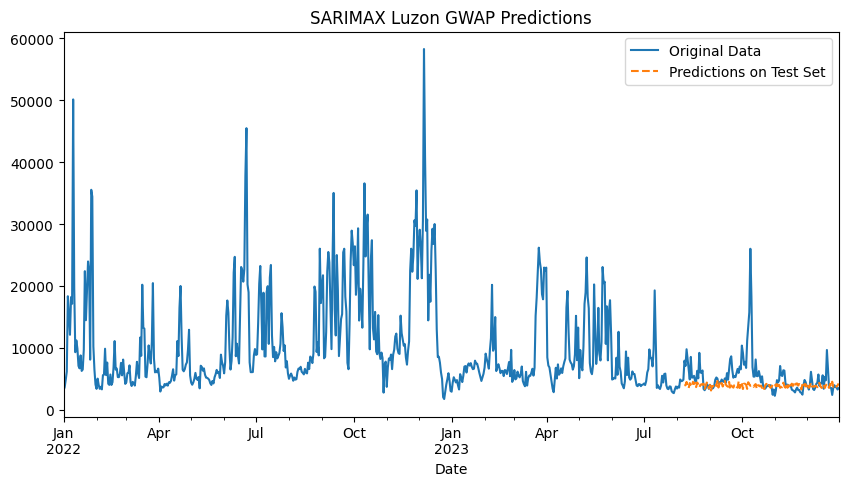

In [57]:
# Calculate MAE for the Luzon GWAP test set
mae_test = mean_absolute_error(GWAP_test_inversed, GWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Luzon GWAP test set
rmse_test = mean_squared_error(GWAP_test_inversed, GWAP_predictions_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
GWAP.plot(ax=ax, label='Original Data')
GWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon GWAP Predictions')
ax.legend()
plt.show()

Mean Absolute Error (MAE) on Test Set: 1945.7382022577126
Root Mean Squared Error (RMSE) on Test Set: 3488.049502665831


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



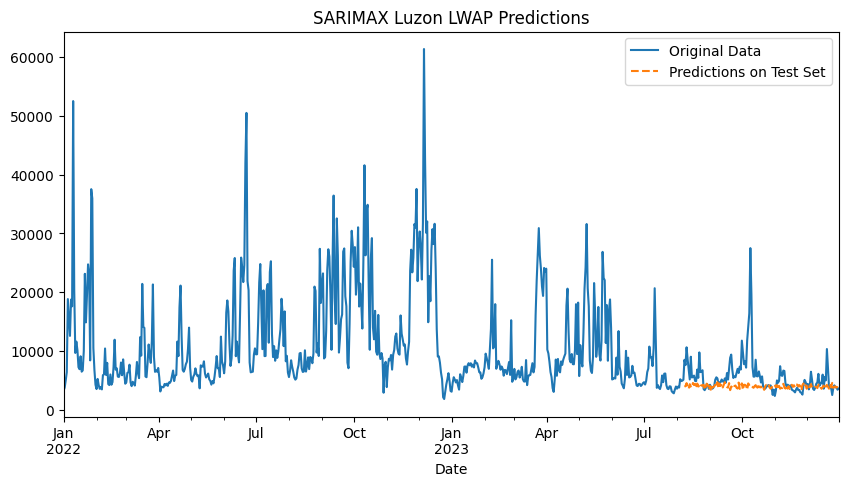

In [58]:
# Calculate MAE for the Luzon LWAP test set
mae_test = mean_absolute_error(LWAP_test_inversed, LWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Luzon GWAP test set
rmse_test = mean_squared_error(LWAP_test_inversed, LWAP_predictions_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original Data')
LWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon LWAP Predictions')
ax.legend()
plt.show()

Applying inverse transformations - rolling